# 🧠 Sentiment Analysis on Amazon Reviews

Mục tiêu: 
- Làm sạch dữ liệu đánh giá sản phẩm bằng PySpark.
- Chuyển đổi dữ liệu đã xử lý sang tensor để huấn luyện mô hình PyTorch.

Công cụ:
- PySpark (xử lý dữ liệu lớn)
- PyTorch (huấn luyện mô hình Deep Learning)


## Khám phá dữ liệu (Exploratory Data Analysis - EDA)

Trong phần này, chúng ta sẽ:
- Đọc dữ liệu gốc từ file `.csv`
- Kiểm tra schema, số lượng dòng/cột
- Kiểm tra dữ liệu thiếu (null/missing)
- Chuẩn hoá cột `Rating`
- Phân tích phân bố điểm đánh giá và cảm xúc
- Tính toán độ dài review
- Phân tích theo thời gian (nếu có cột ngày đánh giá)


### Import thư viện

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import Tokenizer, StopWordsRemover

### Tạo Spark Session

In [2]:
# ==============================================================
# 🔹 Tạo SparkSession
# ==============================================================

spark = (
    SparkSession.builder
    .appName("Amazon_Review_Sentiment")
    .config("spark.driver.memory", "8g")
    .config("spark.executor.memory", "4g")
    .config("spark.executor.cores", "4")
    .config("spark.ui.showConsoleProgress", "false")
    .getOrCreate()
)

spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/26 11:04:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Đọc dữ liệu gốc

In [5]:
# ==============================================================
# 🔹 Đọc dữ liệu gốc
# ==============================================================

data_path = "../data/raw/Amazon_Reviews.csv"

df = spark.read.option("header", True).option("inferSchema", True).csv(data_path)

print("Đọc dữ liệu thành công.")
df.show(5, truncate=False)


Đọc dữ liệu thành công.
+----------------+-------------------------------+-------+------------+------------------------+----------------------+-----------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+
|Reviewer Name   |Profile Link                   |Country|Review Count|Review Date             |Rating                |Review Title                                   |Review Tex

### Thông tin tổng quan về dữ liệu

In [6]:
# ==============================================================
# 🔹 Thông tin tổng quan
# ==============================================================

print("Schema:")
df.printSchema()

print(f"Tổng số dòng: {df.count():,}")
print(f"Tổng số cột: {len(df.columns)}")
print("Danh sách cột:", df.columns)


Schema:
root
 |-- Reviewer Name: string (nullable = true)
 |-- Profile Link: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Review Count: string (nullable = true)
 |-- Review Date: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Review Title: string (nullable = true)
 |-- Review Text: string (nullable = true)
 |-- Date of Experience: string (nullable = true)

Tổng số dòng: 21,656
Tổng số cột: 9
Danh sách cột: ['Reviewer Name', 'Profile Link', 'Country', 'Review Count', 'Review Date', 'Rating', 'Review Title', 'Review Text', 'Date of Experience']


### Kiểm tra giá trị thiếu

In [7]:
# ==============================================================
# 🔹 Kiểm tra giá trị thiếu
# ==============================================================

null_df = df.select([
    F.count(F.when(F.col(c).isNull() | (F.col(c) == ''), c)).alias(c)
    for c in df.columns
])
print("Số lượng giá trị null hoặc rỗng trong từng cột:")
null_df.show(vertical=True)

Số lượng giá trị null hoặc rỗng trong từng cột:
-RECORD 0-----------------
 Reviewer Name      | 0   
 Profile Link       | 141 
 Country            | 436 
 Review Count       | 523 
 Review Date        | 565 
 Rating             | 581 
 Review Title       | 590 
 Review Text        | 595 
 Date of Experience | 920 



### Thống kê cột Rating

In [8]:
# ==============================================================
# 🔹 Thống kê cột Rating
# ==============================================================

df = df.withColumn(
    "Rating",
    F.regexp_extract(F.col("Rating"), r"(\d)(?=\s*out of 5)", 1).cast(IntegerType())
)

# Thống kê điểm đánh giá
rating_stats = df.groupBy("Rating").agg(
    F.count("*").alias("count")
).orderBy("Rating")

print("\n Thống kê điểm Rating:")
rating_stats.show()


 Thống kê điểm Rating:
+------+-----+
|Rating|count|
+------+-----+
|  NULL|  601|
|     1|13123|
|     2| 1227|
|     3|  885|
|     4| 1292|
|     5| 4528|
+------+-----+



### Thống kê độ dài review

In [9]:
# ==============================================================
# 🔹 Thống kê độ dài nội dung Review
# ==============================================================

if "Review Text" in df.columns:
    df = df.withColumn("ReviewLength", F.length(F.col("Review Text")))

    review_stats = df.select(
        F.mean("ReviewLength").alias("mean_len"),
        F.min("ReviewLength").alias("min_len"),
        F.max("ReviewLength").alias("max_len")
    ).collect()[0]

    print(f"Độ dài trung bình: {review_stats['mean_len']:.2f}")
    print(f"Ngắn nhất: {review_stats['min_len']}, Dài nhất: {review_stats['max_len']}")


Độ dài trung bình: 422.60
Ngắn nhất: 6, Dài nhất: 8166


### Phân tích theo thời gian

In [10]:
# ==============================================================
# 🔹 Phân tích theo thời gian (nếu có cột Review Date)
# ==============================================================

if "Review Date" in df.columns:
    df = df.withColumn("Review Date", F.to_date(F.col("Review Date")))
    time_dist = df.groupBy(F.year("Review Date").alias("year")).count().orderBy("year")
    print("Số lượng review theo năm:")
    time_dist.show()

Số lượng review theo năm:
+----+-----+
|year|count|
+----+-----+
|NULL|  601|
|2007|    1|
|2008|    3|
|2009|    9|
|2010|   22|
|2011|  360|
|2012| 1166|
|2013|   88|
|2014|  166|
|2015|  175|
|2016|  317|
|2017|  616|
|2018| 1041|
|2019| 2314|
|2020| 2638|
|2021| 2750|
|2022| 2551|
|2023| 4017|
|2024| 2821|
+----+-----+



## Tiền xử lý dữ liệu (Data Preprocessing)

Trong phần này, chúng ta sẽ:
- Chuẩn hoá cột **Rating** về giá trị số (1–5)
- Gán nhãn **Sentiment** (`positive`, `negative`)
- Làm sạch văn bản: xoá ký tự đặc biệt, chữ thường, loại bỏ stopwords
- Kết hợp tiêu đề + nội dung review
- Lưu dữ liệu đã chuẩn hoá ra file `.parquet` để phục vụ huấn luyện mô hình.


### Chuẩn hoá cột Rating

In [11]:
# ==============================================================
# 🔹 Chuẩn hoá cột Rating
# ==============================================================
df = df.withColumn(
    "Rating",
    F.regexp_extract(F.col("Rating"), r"(\d+)", 1).cast(IntegerType())
)

df = df.filter((F.col("Rating") >= 1) & (F.col("Rating") <= 5))
print("Đã chuẩn hoá cột Rating về khoảng [1–5].")

df.select("Rating").distinct().orderBy("Rating").show()

Đã chuẩn hoá cột Rating về khoảng [1–5].
+------+
|Rating|
+------+
|     1|
|     2|
|     3|
|     4|
|     5|
+------+



### Gán nhãn Sentiment

In [12]:
# ==============================================================
# 🔹 Gán nhãn cảm xúc dựa trên Rating
# ==============================================================

df = df.withColumn(
    "Sentiment",
    F.when(F.col("Rating") <= 2, "negative")
     .otherwise("positive")
)

df.groupBy("Sentiment").count().show()


+---------+-----+
|Sentiment|count|
+---------+-----+
| positive| 6705|
| negative|14350|
+---------+-----+



### Làm sạch văn bản

In [13]:
# ==============================================================
# 🔹 Làm sạch nội dung Review
# ==============================================================

if "Review Title" in df.columns and "Review Text" in df.columns:
    df = df.withColumn("FullReview", F.concat_ws(". ", "Review Title", "Review Text"))
elif "Review Text" in df.columns:
    df = df.withColumnRenamed("Review Text", "FullReview")

df = (
    df.withColumn("FullReview", F.lower("FullReview"))
      .withColumn("FullReview", F.regexp_replace("FullReview", r"[^a-zA-Z0-9\s]", " "))
      .withColumn("FullReview", F.regexp_replace("FullReview", r"\s+", " "))
      .filter(F.length("FullReview") > 10)
)

print("Đã làm sạch văn bản.")
df.select("FullReview").show(5, truncate=False)


Đã làm sạch văn bản.
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|FullReview                                                                                                                                                                                                                                                                                                                                              

### Loại bỏ Stopwords

In [14]:
# ==============================================================
# 🔹 Tokenization & Stopword Removal
# ==============================================================

tokenizer = Tokenizer(inputCol="FullReview", outputCol="Words")
remover = StopWordsRemover(inputCol="Words", outputCol="FilteredWords")

df = tokenizer.transform(df)
df = remover.transform(df)
df = df.withColumn("CleanText", F.concat_ws(" ", "FilteredWords"))
df = df.filter(F.length("CleanText") > 10)

df.select("CleanText").show(5, truncate=False)
print("Đã loại bỏ stopwords.")


+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|CleanText                                                                                                                                                                                                                                                                                                                                                                                             |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Loại bỏ dữ liệu trùng lặp

In [15]:
# ==============================================================
# Loại bỏ dữ liệu trùng lặp
# ==============================================================

before_count = df.count()
df = df.dropDuplicates(["CleanText"])
after_count = df.count()

print(f"Đã loại bỏ {before_count - after_count} dòng trùng lặp.")
print(f"Còn lại {after_count} dòng dữ liệu sau khi làm sạch & unique.")
df.select("CleanText").show(5, truncate=False)

Đã loại bỏ 81 dòng trùng lặp.
Còn lại 20967 dòng dữ liệu sau khi làm sạch & unique.
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|CleanText                                                                                                                                                                                                                                                                                                                                                              |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Giữ cột quan trọng và lưu dữ liệu

In [16]:
# ==============================================================
# 🔹 Giữ cột cần thiết và lưu dữ liệu
# ==============================================================

keep_cols = ["Reviewer Name", "Country", "Review Date", "Rating", "CleanText", "Sentiment"]
df = df.select([c for c in keep_cols if c in df.columns])

print("Dữ liệu đã được xử lý và tinh gọn:")
df.show(5, truncate=False)

output_path = "../data/processed"
df.write.mode("overwrite").parquet(output_path)
print(f"Đã lưu dữ liệu tiền xử lý tại: {output_path}")


Dữ liệu đã được xử lý và tinh gọn:
+-------------+-------+-----------+------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|Reviewer Name|Country|Review Date|Rating|CleanText                                                                                                                                                                                               

### Data Validation sau khi preprocessing

In [17]:
# ==============================================================
# 🔹 Data Validation sau khi preprocessing
# ==============================================================

from pyspark.sql import functions as F

# Kiểm tra null
print("Kiểm tra null:")
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show(vertical=True)

# Kiểm tra trùng lặp
dup_count = df.groupBy("CleanText").count().filter(F.col("count") > 1).count()
print(f"Số dòng trùng lặp: {dup_count}")

# Kiểm tra phân bố rating
df.groupBy("Rating").count().orderBy("Rating").show()

print("Validation hoàn tất – dữ liệu đã sẵn sàng cho feature engineering.")


Kiểm tra null:
-RECORD 0------------
 Reviewer Name | 0   
 Country       | 0   
 Review Date   | 0   
 Rating        | 0   
 CleanText     | 0   
 Sentiment     | 0   

Số dòng trùng lặp: 0
+------+-----+
|Rating|count|
+------+-----+
|     1|13105|
|     2| 1225|
|     3|  879|
|     4| 1274|
|     5| 4484|
+------+-----+

Validation hoàn tất – dữ liệu đã sẵn sàng cho feature engineering.


## Trực quan hóa dữ liệu

### Import thư viện

In [15]:
# ==============================================================
# Import thư viện
# ==============================================================

from pyspark.sql.functions import col, length, to_date, month, year, count, avg
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from wordcloud import WordCloud
from collections import Counter

# Lấy toàn bộ dữ liệu để trực quan (chỉ nên dùng nếu dataset vừa phải)
pdf = df.toPandas()
print("Số dòng dùng cho trực quan hóa:", len(pdf))

# Thiết lập style hiển thị
sns.set(style="whitegrid", palette="pastel")
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (10, 6)

Số dòng dùng cho trực quan hóa: 20967


### Phân bố cảm xúc

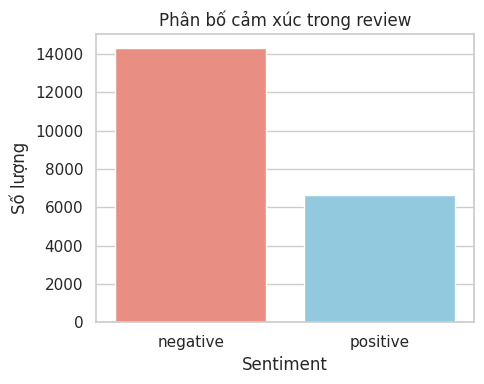

In [19]:
# ==============================================================
# Phân bố cảm xúc
# ==============================================================

sentiment_counts = pdf['Sentiment'].value_counts()
plt.figure(figsize=(5,4))
sns.barplot(x=sentiment_counts.index, hue=sentiment_counts.index, y=sentiment_counts.values, palette=["salmon", "skyblue"])
plt.title("Phân bố cảm xúc trong review")
plt.xlabel("Sentiment")
plt.ylabel("Số lượng")
plt.tight_layout()
plt.show()


### Phân bố rating

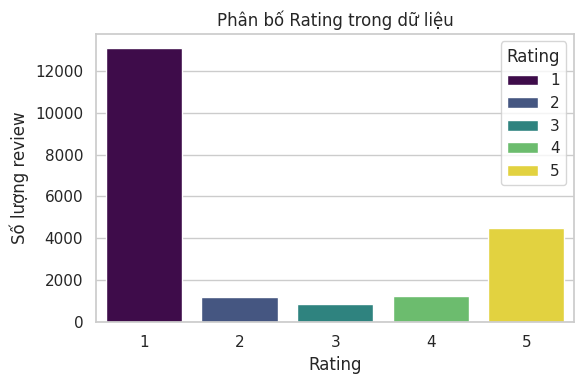

In [20]:
# ==============================================================
# Phân bố rating
# ==============================================================

plt.figure(figsize=(6,4))
sns.countplot(x='Rating', hue='Rating',data=pdf, palette='viridis')
plt.title("Phân bố Rating trong dữ liệu")
plt.xlabel("Rating")
plt.ylabel("Số lượng review")
plt.tight_layout()
plt.show()


### Phân bố độ dài review

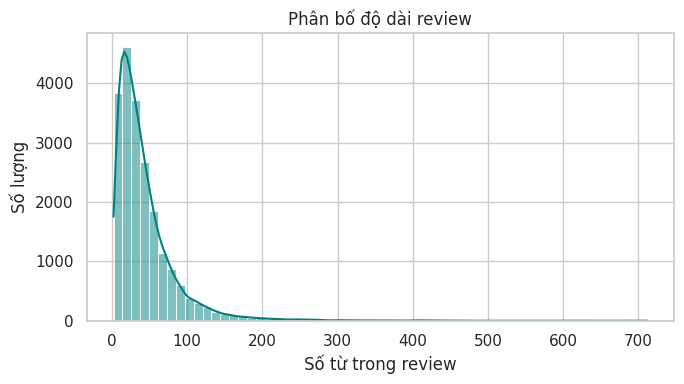

In [21]:
# ==============================================================
# Phân bố độ dài review
# ==============================================================

pdf['review_length'] = pdf['CleanText'].apply(lambda x: len(x.split()))
plt.figure(figsize=(7,4))
sns.histplot(pdf['review_length'], bins=60, color='teal', kde=True)
plt.title("Phân bố độ dài review")
plt.xlabel("Số từ trong review")
plt.ylabel("Số lượng")
plt.tight_layout()
plt.show()


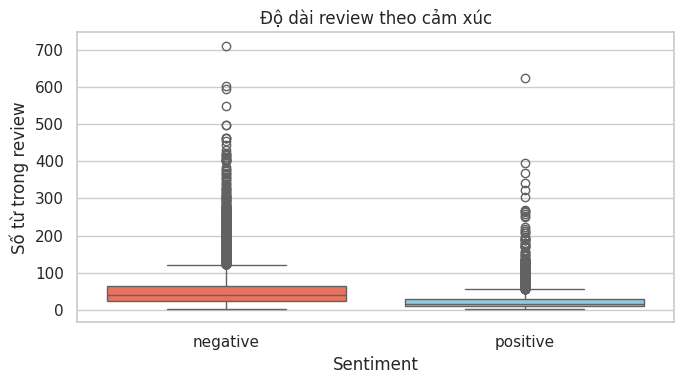

In [22]:
# ==============================================================
# Độ dài review theo cảm xúc
# ==============================================================

plt.figure(figsize=(7,4))
sns.boxplot(x='Sentiment',hue='Sentiment', y='review_length', data=pdf, palette=['tomato','skyblue'])
plt.title("Độ dài review theo cảm xúc")
plt.xlabel("Sentiment")
plt.ylabel("Số từ trong review")
plt.tight_layout()
plt.show()


### Top quốc gia có nhiều review nhất

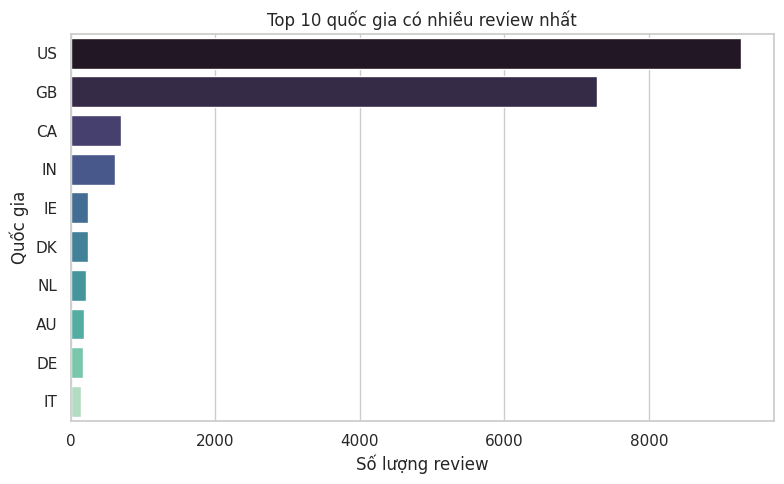

In [23]:
# ==============================================================
# Top quốc gia có nhiều review nhất
# ==============================================================

country_df = (
    df.groupBy("Country")
      .count()
      .orderBy(col("count").desc())
      .limit(10)
      .toPandas()
)

plt.figure(figsize=(8,5))
sns.barplot(y='Country', hue='Country', x='count', data=country_df, palette='mako')
plt.title("Top 10 quốc gia có nhiều review nhất")
plt.xlabel("Số lượng review")
plt.ylabel("Quốc gia")
plt.tight_layout()
plt.show()


### Xu hướng cảm xúc theo thời gian

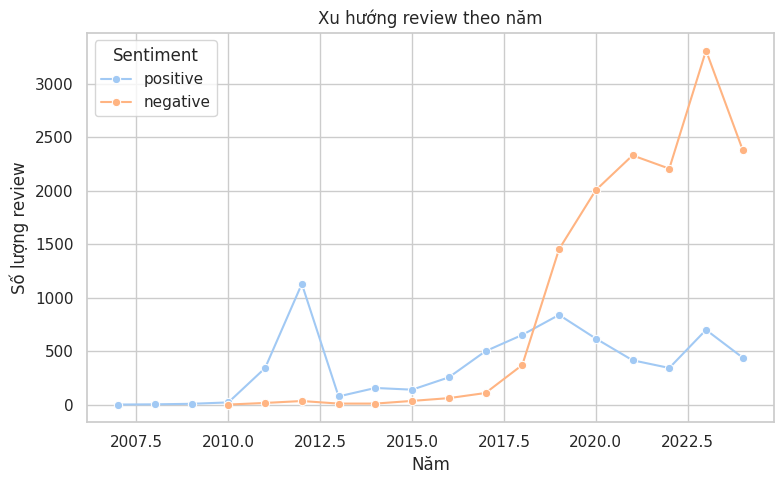

In [24]:
# ==============================================================
# Xu hướng cảm xúc theo thời gian
# ==============================================================

df_date = df.withColumn("ReviewDate", to_date(col("Review Date"), "yyyy-MM-dd"))
trend_df = (
    df_date.groupBy(year("ReviewDate").alias("Year"), "Sentiment")
    .agg(count("*").alias("count"))
    .orderBy("Year")
    .toPandas()
)

plt.figure(figsize=(8,5))
sns.lineplot(x="Year", y="count", hue="Sentiment", data=trend_df, marker="o")
plt.title("Xu hướng review theo năm")
plt.xlabel("Năm")
plt.ylabel("Số lượng review")
plt.tight_layout()
plt.show()


### Trung bình rating theo năm

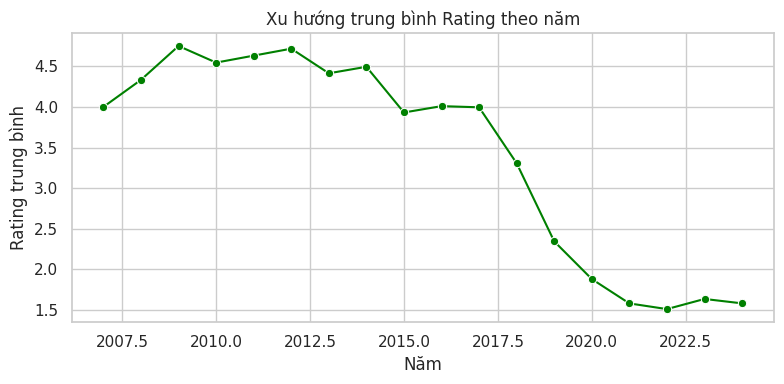

In [25]:
# ==============================================================
# Trung bình rating theo năm
# ==============================================================

avg_rating_df = (
    df_date.groupBy(year("ReviewDate").alias("Year"))
    .agg(avg("Rating").alias("avg_rating"))
    .orderBy("Year")
    .toPandas()
)

plt.figure(figsize=(8,4))
sns.lineplot(x="Year", y="avg_rating", data=avg_rating_df, marker="o", color="green")
plt.title("Xu hướng trung bình Rating theo năm")
plt.xlabel("Năm")
plt.ylabel("Rating trung bình")
plt.tight_layout()
plt.show()


### Trực quan hóa từ xuất hiện nhiều nhất

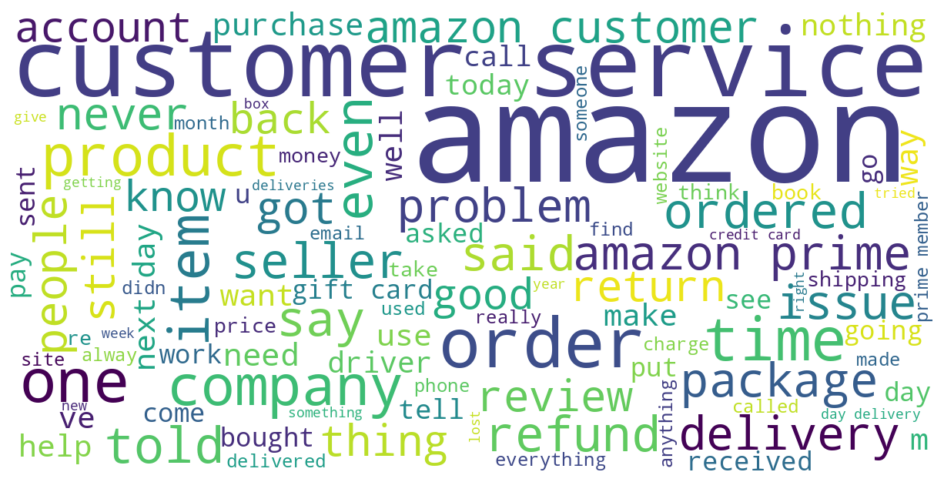

In [26]:
# ==============================================================
# Word Cloud – Trực quan hóa từ xuất hiện nhiều nhất
# ==============================================================

# Gộp tất cả text lại
all_text = " ".join(pdf["CleanText"].tolist())

# Tạo WordCloud
wordcloud = WordCloud(width=1200, height=600, background_color="white",
                      colormap="viridis", max_words=100).generate(all_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


### Tần suất xuất hiện của các từ

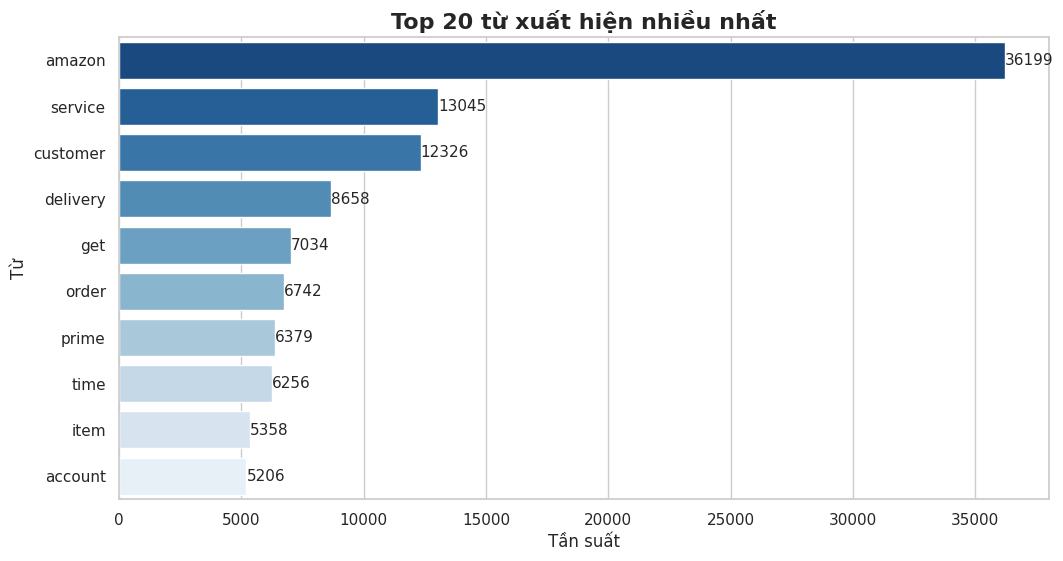

In [27]:
# ==============================================================
# Word Count – Tần suất xuất hiện của các từ
# ==============================================================

# Tách từ và đếm tần suất
word_counts = Counter(" ".join(pdf["CleanText"].tolist()).split())

# Lấy top 10 từ phổ biến nhất
top_words = pd.DataFrame(word_counts.most_common(10), columns=["word", "count"])

# Vẽ biểu đồ với số hiển thị trên thanh
plt.figure(figsize=(12, 6))
sns.barplot(data=top_words, x="count", y="word", hue="word", dodge=False, palette="Blues_r")
plt.title("Top 20 từ xuất hiện nhiều nhất", fontsize=16, fontweight="bold")
plt.xlabel("Tần suất")
plt.ylabel("Từ")

# Hiển thị số trên mỗi thanh
for i, v in enumerate(top_words["count"]):
    plt.text(v + 0.5, i, str(v), va="center", fontsize=11)

plt.legend([], [], frameon=False)
plt.show()

### Phân tích từ theo cảm xúc - từ điển NRC

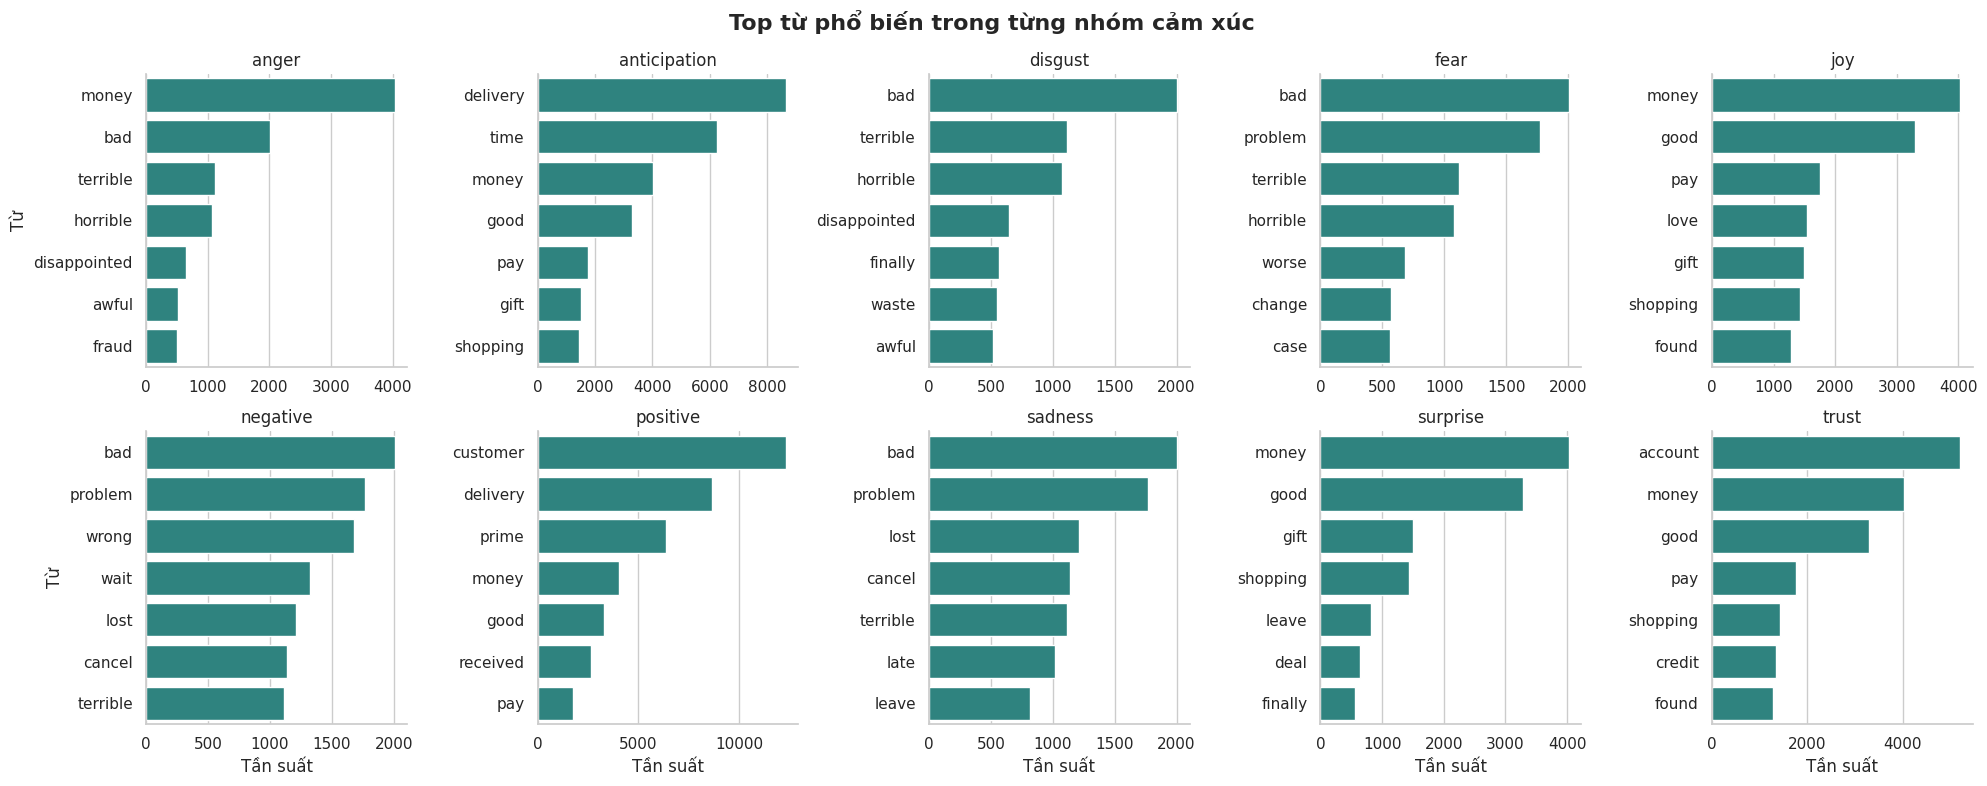

In [28]:
# ==============================================================
# Phân tích từ theo cảm xúc - từ điển NRC
# ==============================================================


# Đọc từ điển NRC
nrc = pd.read_csv("../data/external/NRC.csv")

# Chuẩn hóa văn bản thành danh sách từ
rows = []
for _, row in pdf.iterrows():
    for w in row["CleanText"].split():
        rows.append((w.lower(), row["Sentiment"]))
words_df = pd.DataFrame(rows, columns=["word", "Sentiment"])

# Gộp với từ điển NRC để lấy cảm xúc
merged = words_df.merge(nrc, on="word", how="inner")

# Đếm tần suất từng từ trong từng nhóm cảm xúc
word_counts = (
    merged.groupby(["sentiment", "word"])
    .size()
    .reset_index(name="count")
    .sort_values(["sentiment", "count"], ascending=[True, False])
)

# Lấy top 7 từ trong mỗi nhóm cảm xúc
top_words = (
    word_counts.groupby("sentiment")
    .head(7)
    .sort_values(["sentiment", "count"], ascending=[True, False])
)

# Vẽ biểu đồ
sns.set(style="whitegrid")
g = sns.FacetGrid(top_words, col="sentiment", col_wrap=5, sharex=False, sharey=False, height=4)
g.map_dataframe(sns.barplot, x="count", y="word", hue="sentiment", palette="viridis", legend=False)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Tần suất", "Từ")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Top từ phổ biến trong từng nhóm cảm xúc", fontsize=16, fontweight="bold")
plt.show()


### Phân tích cụm từ - Bigram & Trigram

In [29]:
# ==============================================================
# PHÂN TÍCH CỤM TỪ - BIGRAM & TRIGRAM
# ==============================================================

from sklearn.feature_extraction.text import CountVectorizer

# Hàm tạo Bigram - Trigram
def get_top_ngrams(corpus, ngram_range=(2, 2), n=None):
    """
    Trả về top n bigram/trigram phổ biến nhất
    """
    vec = CountVectorizer(ngram_range=ngram_range, stop_words=None).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [
        (word, int(sum_words[0, idx])) for word, idx in vec.vocabulary_.items()
    ]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return pd.DataFrame(words_freq[:n], columns=["word", "freq"])



# Tạo Bigram - Trigram
bigram = get_top_ngrams(pdf["CleanText"], ngram_range=(2, 2), n=10)
trigram = get_top_ngrams(pdf["CleanText"], ngram_range=(3, 3), n=10)


In [30]:
sns.set(style="whitegrid")
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["axes.unicode_minus"] = False

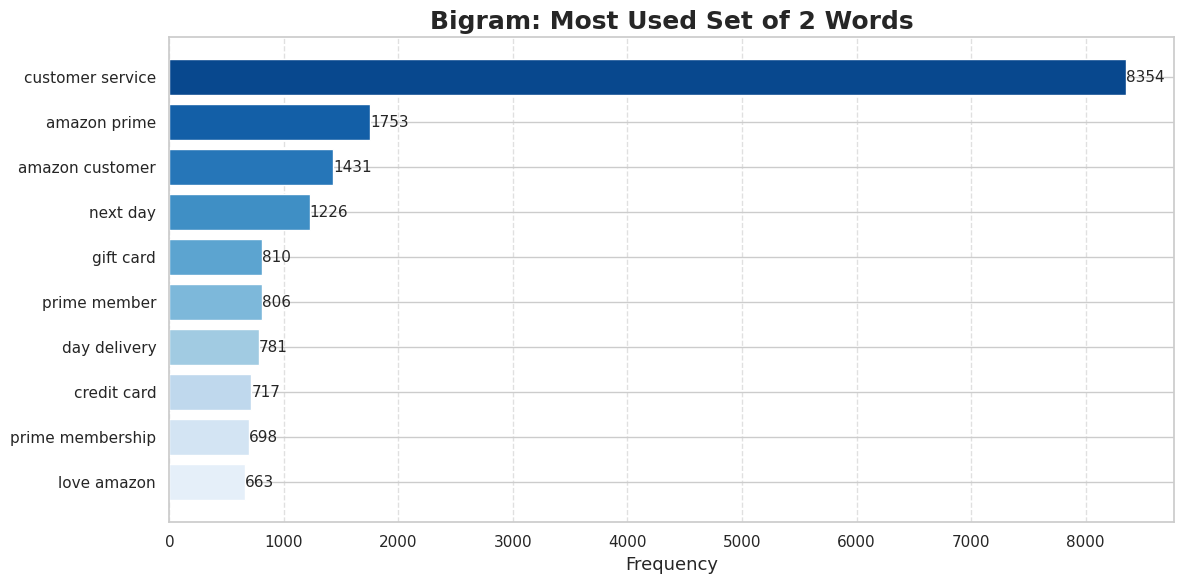

In [31]:
# --- BIGRAM ---
plt.figure(figsize=(12, 6))
bigram_sorted = bigram.sort_values("freq", ascending=True)
colors = sns.color_palette("Blues", n_colors=len(bigram_sorted))

plt.barh(bigram_sorted["word"], bigram_sorted["freq"], color=colors)
for i, v in enumerate(bigram_sorted["freq"]):
    plt.text(v + 0.5, i, f"{v}", va="center", fontsize=11)
plt.title("Bigram: Most Used Set of 2 Words", fontsize=18, weight="bold")
plt.xlabel("Frequency", fontsize=13)
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

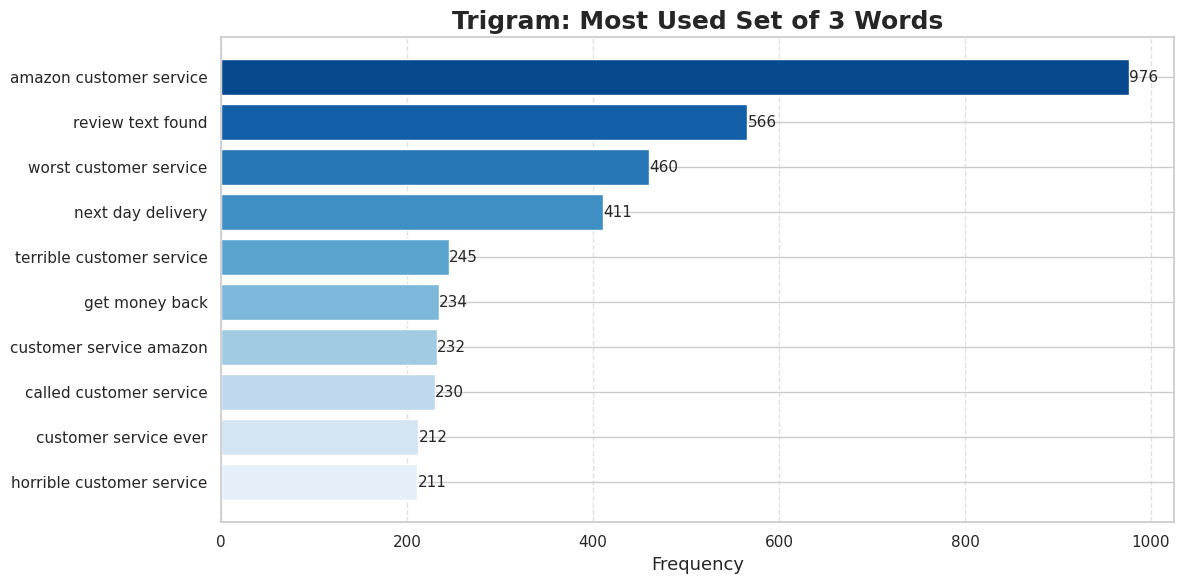

In [32]:
# --- TRIGRAM ---
plt.figure(figsize=(12, 6))
trigram_sorted = trigram.sort_values("freq", ascending=True)
colors = sns.color_palette("Blues", n_colors=len(trigram_sorted))

bars = plt.barh(trigram_sorted["word"], trigram_sorted["freq"], color=colors)
for i, v in enumerate(trigram_sorted["freq"]):
    plt.text(v + 0.5, i, f"{v}", va="center", fontsize=11)
plt.title("Trigram: Most Used Set of 3 Words", fontsize=18, weight="bold")
plt.xlabel("Frequency", fontsize=13)
plt.ylabel("")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

## Xây dựng mô hình Machine Learning

### Import thư viện

In [33]:
# ==============================================================
# Import thư viện
# ==============================================================
from pyspark.ml.feature import HashingTF, IDF, StringIndexer, Tokenizer
from pyspark.ml.classification import LogisticRegression, LinearSVC, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import classification_report

### Đọc dữ liệu và trích xuất đặc trưng

In [34]:
# ==============================================================
# Đọc dữ liệu
# ==============================================================
df = spark.read.parquet("../data/processed/")
df = df.select("CleanText", "Sentiment").dropna()

print("Số lượng bản ghi:", df.count())
df.show(5, truncate=False)

Số lượng bản ghi: 20967
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|CleanText                                                                                                                                                                                                                  

### Chuẩn bị dữ liệu cho mô hình

In [35]:
# ==============================================================
# Chuẩn bị dữ liệu cho mô hình
# ==============================================================
tokenizer = Tokenizer(inputCol="CleanText", outputCol="words")
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=5000)
idf = IDF(inputCol="rawFeatures", outputCol="features")

label_indexer = StringIndexer(inputCol="Sentiment", outputCol="label")

### Định nghĩa 3 mô hình

In [36]:
# ==============================================================
# Định nghĩa mô hình
# ==============================================================
lr = LogisticRegression(maxIter=50)
svm = LinearSVC(maxIter=50)
rf = RandomForestClassifier(numTrees=100, maxDepth=10)

### Train và Cross Validation cho từng mô hình

In [37]:
# ==============================================================
# Tạo Pipeline
# ==============================================================
def make_pipeline(model):
    return Pipeline(stages=[tokenizer, hashingTF, idf, label_indexer, model])

In [38]:
# ==============================================================
# Chia dữ liệu train/test
# ==============================================================
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)
print("Train:", train_df.count(), "Test:", test_df.count())

Train: 16901 Test: 4066


In [39]:
# ==============================================================
# Metrics đánh giá mô hình
# ==============================================================
metrics = {
    "accuracy": MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy"),
    "f1": MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1"),
    "precision": MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision"),
    "recall": MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
}

def evaluate_all(pred):
    return {m: ev.evaluate(pred) for m, ev in metrics.items()}


In [40]:
# ==============================================================
# Train mô hình
# ==============================================================
models = {
    "LogisticRegression": (lr, ParamGridBuilder().addGrid(lr.regParam, [0.1, 0.01]).build()),
    "LinearSVM": (svm, ParamGridBuilder().addGrid(svm.regParam, [0.1, 0.01]).build()),
    "RandomForest": (rf, ParamGridBuilder().addGrid(rf.maxDepth, [10, 20]).addGrid(rf.numTrees, [100, 200]).build())
}

results = []

for name, (model, grid) in models.items():
    print(f"\n🔹 Training {name} ...")
    pipeline = make_pipeline(model)
    cv = CrossValidator(estimator=pipeline,
                        estimatorParamMaps=grid,
                        evaluator=metrics["accuracy"],
                        numFolds=5,
                        parallelism=2)
    cv_model = cv.fit(train_df)
    preds = cv_model.transform(test_df)
    
    # Tính metric
    res = evaluate_all(preds)
    print(f"\n{name} Evaluation Report")
    print(f"Accuracy:  {res['accuracy']:.4f}")
    print(f"Precision: {res['precision']:.4f}")
    print(f"Recall:    {res['recall']:.4f}")
    print(f"F1-score:  {res['f1']:.4f}")

    # Lưu model
    save_path = f"../models/ml/{name.lower()}_model"
    cv_model.bestModel.write().overwrite().save(save_path)
    print(f"Saved {name} to {save_path}")

    # Lưu kết quả
    results.append((name, res, preds))


🔹 Training LogisticRegression ...

LogisticRegression Evaluation Report
Accuracy:  0.9144
Precision: 0.9138
Recall:    0.9144
F1-score:  0.9134
Saved LogisticRegression to ../models/ml/logisticregression_model

🔹 Training LinearSVM ...

LinearSVM Evaluation Report
Accuracy:  0.9083
Precision: 0.9080
Recall:    0.9083
F1-score:  0.9081
Saved LinearSVM to ../models/ml/linearsvm_model

🔹 Training RandomForest ...

RandomForest Evaluation Report
Accuracy:  0.8490
Precision: 0.8674
Recall:    0.8490
F1-score:  0.8353
Saved RandomForest to ../models/ml/randomforest_model


In [41]:
# ==============================================================
# Đánh giá mô hình
# ==============================================================
for name, res, preds in results:
    print(f"\nDetailed classification report for {name}:")
    preds_pd = preds.select("label", "prediction").toPandas()
    print(classification_report(preds_pd["label"], preds_pd["prediction"], target_names=["negative", "positive"]))

print("\n Đã train và lưu toàn bộ mô hình thành công!")


Detailed classification report for LogisticRegression:
              precision    recall  f1-score   support

    negative       0.92      0.96      0.94      2773
    positive       0.90      0.82      0.86      1293

    accuracy                           0.91      4066
   macro avg       0.91      0.89      0.90      4066
weighted avg       0.91      0.91      0.91      4066


Detailed classification report for LinearSVM:
              precision    recall  f1-score   support

    negative       0.93      0.94      0.93      2773
    positive       0.86      0.85      0.85      1293

    accuracy                           0.91      4066
   macro avg       0.90      0.89      0.89      4066
weighted avg       0.91      0.91      0.91      4066


Detailed classification report for RandomForest:
              precision    recall  f1-score   support

    negative       0.82      0.99      0.90      2773
    positive       0.96      0.55      0.70      1293

    accuracy                 

In [42]:
# ==============================================================
# So sánh và chọn mô hình tốt nhất
# ==============================================================

# Tạo DataFrame từ kết quả metrics
results_df = pd.DataFrame([
    {
        "Model": name,
        "Accuracy": res["accuracy"],
        "Precision": res["precision"],
        "Recall": res["recall"],
        "F1": res["f1"]
    }
    for name, res, _ in results
])

# Sắp xếp theo Accuracy giảm dần
results_df = results_df.sort_values(by="Accuracy", ascending=False)
print("\n==============================")
print("KẾT QUẢ SO SÁNH GIỮA CÁC MÔ HÌNH")
print("==============================")
print(results_df)

# Lấy mô hình tốt nhất
best_model = results_df.iloc[0]
print("\n==============================")
print(f"MÔ HÌNH TỐT NHẤT: {best_model['Model']}")
print(f"Accuracy : {best_model['Accuracy']:.4f}")
print(f"Precision: {best_model['Precision']:.4f}")
print(f"Recall   : {best_model['Recall']:.4f}")
print(f"F1-score : {best_model['F1']:.4f}")
print("==============================")



KẾT QUẢ SO SÁNH GIỮA CÁC MÔ HÌNH
                Model  Accuracy  Precision    Recall        F1
0  LogisticRegression  0.914412   0.913810  0.914412  0.913386
1           LinearSVM  0.908264   0.907973  0.908264  0.908100
2        RandomForest  0.848992   0.867377  0.848992  0.835264

MÔ HÌNH TỐT NHẤT: LogisticRegression
Accuracy : 0.9144
Precision: 0.9138
Recall   : 0.9144
F1-score : 0.9134


## Xây dựng mô hình Deep Learning

### Import thư viện

In [19]:
# ==============================================================
# Import thư viện
# ==============================================================

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import numpy as np
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

print("PyTorch version:", torch.__version__)


PyTorch version: 2.8.0+cu128


### Đọc dữ liệu từ Spark

In [14]:
# ==============================================================
# Đọc dữ liệu từ Spark
# ==============================================================

df = spark.read.parquet("../data/processed/")

# Chuyển sang pandas để huấn luyện với PyTorch
pandas_df = df.select("CleanText", "Sentiment").toPandas()
pandas_df = pandas_df.dropna()

print("Dữ liệu sẵn sàng để train:", pandas_df.shape)
pandas_df.head()

Dữ liệu sẵn sàng để train: (20967, 2)


,CleanText,Sentiment
0,0 win complaint 0 win complaint amazon right ...,negative
1,100 shipping didn tell 100 shipping didn tell...,negative
2,10000000000 stars bad company 10000000000 sta...,negative
3,514 billion revenues least come good customer...,negative
4,600 order missing ve lot amazon orders incorr...,negative


### Tokenize & Encode dữ liệu

In [15]:
# ==============================================================
# Tokenize & Encode dữ liệu
# ==============================================================

def simple_tokenize(text):
    return word_tokenize(text.lower())

# Xây vocab
MAX_VOCAB = 10000
MAX_LEN = 100

tokenized_texts = [simple_tokenize(t) for t in pandas_df["CleanText"]]

# Đếm tần suất
word_counts = Counter([word for tokens in tokenized_texts for word in tokens])
most_common_words = [w for w, _ in word_counts.most_common(MAX_VOCAB - 2)]

# Xây vocab dictionary
word2idx = {word: idx + 2 for idx, word in enumerate(most_common_words)}
word2idx["<PAD>"] = 0
word2idx["<OOV>"] = 1

# Encode câu
def encode_text(tokens):
    return [word2idx.get(w, 1) for w in tokens]

encoded_texts = [encode_text(t) for t in tokenized_texts]

# Padding
def pad_sequence(seq, max_len=MAX_LEN):
    if len(seq) < max_len:
        return seq + [0] * (max_len - len(seq)) 
    else:
        return seq[:max_len]

X = np.array([pad_sequence(seq, MAX_LEN) for seq in encoded_texts])

# Encode nhãn
encoder = LabelEncoder()
y = encoder.fit_transform(pandas_df["Sentiment"])

# Chia train/test/val
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765, random_state=42, stratify=y_train_val
)  

print("Train:", len(X_train), "Val:", len(X_val), "Test:", len(X_test))

Train: 14675 Val: 3146 Test: 3146


### Tạo Dataset và DataLoader

In [16]:
# ==============================================================
# Tạo Dataset và DataLoader
# ==============================================================

class ReviewDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(ReviewDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader   = DataLoader(ReviewDataset(X_val, y_val), batch_size=64)
test_loader  = DataLoader(ReviewDataset(X_test, y_test), batch_size=64)


### Mô hình LSTM cơ bản

In [17]:
# ==============================================================
# Mô hình LSTM cơ bản
# ==============================================================

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128, num_classes=2, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)
    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        out = self.dropout(h_n[-1])
        return self.fc(out)

### Mô hình BiLSTM

In [18]:
# ==============================================================
# Mô hình BiLSTM
# ==============================================================

class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128, num_classes=2, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.bilstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim*2, num_classes)
    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.bilstm(x)
        h = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)
        out = self.dropout(h)
        return self.fc(out)


### Hàm train chung cho LSTM & BiLSTM

In [27]:
# ==============================================================
# Hàm train chung cho LSTM & BiLSTM
# ==============================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, train_loader, val_loader, num_epochs=5, lr=1e-3):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        # Validate
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y_batch.cpu().numpy())
        acc = accuracy_score(all_labels, all_preds)
        prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        rec  = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        f1   = f1_score(all_labels, all_preds, average='weighted')
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.3f}, Val Acc: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

    return model


### Train LSTM và BiLSTM

In [28]:
# ==============================================================
# Train LSTM và BiLSTM
# ==============================================================

vocab_size = len(word2idx)
num_classes = len(encoder.classes_)

print("🔹 Training LSTM...")
lstm_model = LSTMClassifier(vocab_size, num_classes=num_classes)
lstm_model = train_model(lstm_model, train_loader, val_loader, num_epochs=5)

print("\n🔹 Training BiLSTM...")
bilstm_model = BiLSTMClassifier(vocab_size, num_classes=num_classes)
bilstm_model = train_model(bilstm_model, train_loader, val_loader, num_epochs=5)


🔹 Training LSTM...
Epoch 1/5, Loss: 142.387, Val Acc: 0.6834, Precision: 0.4670, Recall: 0.6834, F1: 0.5549
Epoch 2/5, Loss: 123.885, Val Acc: 0.8032, Precision: 0.8292, Recall: 0.8032, F1: 0.7763
Epoch 3/5, Loss: 78.908, Val Acc: 0.8910, Precision: 0.8899, Recall: 0.8910, F1: 0.8891
Epoch 4/5, Loss: 59.218, Val Acc: 0.8903, Precision: 0.8897, Recall: 0.8903, F1: 0.8880
Epoch 5/5, Loss: 49.414, Val Acc: 0.9075, Precision: 0.9085, Recall: 0.9075, F1: 0.9079

🔹 Training BiLSTM...
Epoch 1/5, Loss: 83.365, Val Acc: 0.9011, Precision: 0.9002, Recall: 0.9011, F1: 0.9000
Epoch 2/5, Loss: 55.218, Val Acc: 0.9015, Precision: 0.9006, Recall: 0.9015, F1: 0.9000
Epoch 3/5, Loss: 41.662, Val Acc: 0.9034, Precision: 0.9049, Recall: 0.9034, F1: 0.9039
Epoch 4/5, Loss: 30.793, Val Acc: 0.9180, Precision: 0.9173, Recall: 0.9180, F1: 0.9173
Epoch 5/5, Loss: 34.581, Val Acc: 0.9129, Precision: 0.9130, Recall: 0.9129, F1: 0.9112


### Lưu trọng số mô hình

In [29]:
# ==============================================================
# Lưu trọng số mô hình
# ==============================================================

torch.save(lstm_model.state_dict(), "../models/dl/lstm_model.pt")
torch.save(bilstm_model.state_dict(), "../models/dl/bilstm_model.pt")

print("Đã lưu mô hình LSTM và BiLSTM vào thư mục models/dl/")


Đã lưu mô hình LSTM và BiLSTM vào thư mục models/dl/


### Đánh giá chi tiết

In [30]:
def evaluate_model(model, data_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted')
    rec  = recall_score(all_labels, all_preds, average='weighted')
    f1   = f1_score(all_labels, all_preds, average='weighted')
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

lstm_metrics = evaluate_model(lstm_model, test_loader)
bilstm_metrics = evaluate_model(bilstm_model, test_loader)

print("\nLSTM Test Metrics:", lstm_metrics)
print("BiLSTM Test Metrics:", bilstm_metrics)


LSTM Test Metrics: {'accuracy': 0.8976478067387158, 'precision': 0.8977608501809128, 'recall': 0.8976478067387158, 'f1': 0.89770271404973}
BiLSTM Test Metrics: {'accuracy': 0.9075015893197711, 'precision': 0.9090513258360811, 'recall': 0.9075015893197711, 'f1': 0.9048917143668872}


## Fine-tune BERT

### Import thư viện

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
import torch

### Đọc và xử lý dữ liệu từ Spark

In [33]:
# ==============================================================
# Đọc và xử lý dữ liệu từ Spark
# ==============================================================
df = spark.read.parquet("../data/processed/")
pandas_df = df.select("CleanText", "Sentiment").toPandas().dropna()

# Chuẩn hóa nhãn
label_mapping = {"negative": 0, "positive": 1}
pandas_df["label"] = pandas_df["Sentiment"].map(label_mapping)

print("Dữ liệu sẵn sàng:", pandas_df.shape)
pandas_df.head()

Dữ liệu sẵn sàng: (20967, 3)


,CleanText,Sentiment,label
0,0 win complaint 0 win complaint amazon right ...,negative,0
1,100 shipping didn tell 100 shipping didn tell...,negative,0
2,10000000000 stars bad company 10000000000 sta...,negative,0
3,514 billion revenues least come good customer...,negative,0
4,600 order missing ve lot amazon orders incorr...,negative,0


### Chia dữ liệu train/test

In [35]:
# ==============================================================
# Chia dữ liệu train/test
# ==============================================================

# Chia train (70%) và temp (30% = val + test)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    pandas_df["CleanText"].tolist(),
    pandas_df["label"].tolist(),
    test_size=0.3,
    random_state=42,
    stratify=pandas_df["label"]
)

# Chia temp thành validation (15%) và test (15%)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,  # 0.5 * 30% = 15%
    random_state=42,
    stratify=temp_labels
)

print(f"Train size: {len(train_texts)}, Val size: {len(val_texts)}, Test size: {len(test_texts)}")


Train size: 14676, Val size: 3145, Test size: 3146


### Tokenize dữ liệu

In [36]:
# ==============================================================
# Tokenize dữ liệu
# ==============================================================

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings   = tokenizer(val_texts, truncation=True, padding=True, max_length=128)
test_encodings  = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

### Tạo Dataset cho PyTorch

In [37]:
# ==============================================================
# Tạo Dataset cho PyTorch
# ==============================================================
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset   = SentimentDataset(val_encodings, val_labels)
test_dataset  = SentimentDataset(test_encodings, test_labels)

print("Dataset ready for fine-tuning!")

Dataset ready for fine-tuning!


### Fine-tune BERT với HuggingFace Trainer

In [38]:
# ==============================================================
# Fine-tune BERT với HuggingFace Trainer
# ==============================================================

from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

training_args = TrainingArguments(
    output_dir="../models/dl/bert_sentiment_model/results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="../models/dl/bert_sentiment_model/logs",
    logging_strategy="steps",
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    do_train=True,
    do_eval=True
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
# ==============================================================
# Định nghĩa metrics để Trainer tự đánh giá
# ==============================================================
import numpy as np
from evaluate import load

accuracy_metric = load("accuracy")
f1_metric = load("f1")
precision_metric = load("precision")
recall_metric = load("recall")

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    
    acc = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
    f1 = f1_metric.compute(predictions=preds, references=labels)["f1"]
    precision = precision_metric.compute(predictions=preds, references=labels)["precision"]
    recall = recall_metric.compute(predictions=preds, references=labels)["recall"]
    
    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

### Huấn luyện mô hình

In [40]:
# ==============================================================
# Huấn luyện mô hình
# ==============================================================
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,   # <-- validation set
    compute_metrics=compute_metrics,
)

print("Bắt đầu fine-tune DistilBERT ...")
trainer.train()

Bắt đầu fine-tune DistilBERT ...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.199300,0.202779,0.928140,0.886432,0.886432,0.886432
2,0.161900,0.191514,0.934817,0.892501,0.933114,0.855276
3,0.104300,0.244003,0.934817,0.892614,0.932166,0.856281


TrainOutput(global_step=2754, training_loss=0.16745309476499204, metrics={'train_runtime': 623.9529, 'train_samples_per_second': 70.563, 'train_steps_per_second': 4.414, 'total_flos': 1458068657006592.0, 'train_loss': 0.16745309476499204, 'epoch': 3.0})

### Đánh giá mô hình trên test set

In [41]:
# ==============================================================
# Đánh giá mô hình trên test set
# ==============================================================
metrics = trainer.evaluate(test_dataset)
print("\n==============================")
print("ĐÁNH GIÁ MÔ HÌNH TRÊN TEST SET")
print("==============================")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


ĐÁNH GIÁ MÔ HÌNH TRÊN TEST SET
eval_loss: 0.1716
eval_accuracy: 0.9450
eval_f1: 0.9103
eval_precision: 0.9411
eval_recall: 0.8815
eval_runtime: 12.5602
eval_samples_per_second: 250.4740
eval_steps_per_second: 15.6840
epoch: 3.0000


### Lưu mô hình đã fine-tune

In [42]:
# ==============================================================
# Lưu mô hình đã fine-tune
# ==============================================================
model.save_pretrained("../models/dl/bert_sentiment_model")
tokenizer.save_pretrained("../models/dl/bert_sentiment_model")

print("\n Mô hình đã lưu tại ../models/dl/bert_sentiment_model")


 Mô hình đã lưu tại ../models/dl/bert_sentiment_model
